# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
# used to supress display of warnings
import warnings

# os is used to provide a way of using operating system dependent functionality
# We use it for setting working folder
import os

# Pandas is used for data manipulation and analysis
import pandas as pd 

# Numpy is used for large, multi-dimensional arrays and matrices, along with mathematical operators on these arrays
import numpy as np

# Matplotlib is a data visualization library for 2D plots of arrays, built on NumPy arrays 
# and designed to work with the broader SciPy stack
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches # For plotting Bounding Boxes

# Seaborn is based on matplotlib, which aids in drawing attractive and informative statistical graphics.
import seaborn as sns

# Image library
import cv2

# Tensorflow 
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

### Mount to drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


### Change directory

In [4]:
project_path = r"/content/drive/MyDrive/Great_Learning/Lab AIML/Advanced Computer Vision"
os.chdir(project_path)
os.getcwd()

'/content/drive/MyDrive/Great_Learning/Lab AIML/Advanced Computer Vision'

In [5]:
#Extracting .rar files using patool
# !pip install patool
# import patoolib
# patoolib.extract_archive("images_racoon.rar")

# OR

!unrar x "images_racoon.rar"

In [6]:
os.listdir(project_path)

['images',
 'train_labels.csv',
 'images_racoon.rar',
 'vgg_logs',
 'model.png',
 'R10_Internal_Lab_Question_Notebook_Dany_Bright.ipynb',
 'pgp-aiml-pune-feb20-R10_Internal_Lab_Question_Notebook.ipynb']

### Load the training data from train.csv file

In [7]:
data_raw = pd.read_csv("train_labels.csv")
data_raw.sample(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
93,raccoon-83.jpg,660,371,raccoon,104,3,509,369
153,raccoon-148.jpg,500,375,raccoon,309,172,428,315
12,raccoon-182.jpg,500,500,raccoon,17,122,279,499
122,raccoon-50.jpg,275,183,raccoon,36,2,174,172
151,raccoon-100.jpg,960,576,raccoon,548,10,954,520


### Print the shape of the train dataset

In [8]:
print("Shape of train dataset: ", data_raw.shape)

Shape of train dataset:  (173, 8)


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [9]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width and height, x0, y0, x1, y1 in individual variables. <br>
1. Create a list variable known as 'paths' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be resized to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [10]:
paths = []
coords = np.zeros((len(data_raw),4))

In [11]:
for index, row in data_raw.iterrows():
  filename = row['filename']
  paths.append(os.path.join(os.getcwd(), "images", filename))

  coords[index][0] = (row['xmin'] / row['width']) * IMAGE_SIZE
  coords[index][1] = (row['ymin'] / row['height']) * IMAGE_SIZE
  coords[index][2] = (row['xmax'] / row['width']) * IMAGE_SIZE
  coords[index][3] = (row['ymax'] / row['height']) * IMAGE_SIZE

In [12]:
paths[:5]

['/content/drive/MyDrive/Great_Learning/Lab AIML/Advanced Computer Vision/images/raccoon-17.jpg',
 '/content/drive/MyDrive/Great_Learning/Lab AIML/Advanced Computer Vision/images/raccoon-11.jpg',
 '/content/drive/MyDrive/Great_Learning/Lab AIML/Advanced Computer Vision/images/raccoon-63.jpg',
 '/content/drive/MyDrive/Great_Learning/Lab AIML/Advanced Computer Vision/images/raccoon-63.jpg',
 '/content/drive/MyDrive/Great_Learning/Lab AIML/Advanced Computer Vision/images/raccoon-60.jpg']

In [13]:
coords[9]

array([42.996139  ,  5.27835052, 89.94594595, 58.72164948])

In [14]:
coords.shape

(173, 4)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [15]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3))
for i, Image in enumerate(paths):
  #Read the image
  img = cv2.imread(Image)
  #Resize the image
  img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
  #Convert BGR format (used by opencv to RGB format used by matplotlib)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # Preprocessing the image for MobileNet
  batch_images[i] = tf.keras.applications.mobilenet.preprocess_input(np.array(img, dtype=np.float32))

In [16]:
batch_images[0]

array([[[-0.56078434, -0.372549  , -0.47450978],
        [-0.87450981, -0.71764708, -0.80392158],
        [-0.92156863, -0.83529413, -0.88235295],
        ...,
        [-0.10588235,  0.38823533, -0.23137254],
        [ 0.12941182,  0.58431375,  0.18431377],
        [ 0.12156868,  0.52156866,  0.27843142]],

       [[-0.31764704, -0.14509803, -0.23921567],
        [-1.        , -0.89803922, -0.97647059],
        [-0.88235295, -0.79607844, -0.84313726],
        ...,
        [-0.30196077,  0.1686275 , -0.39607841],
        [-0.12941176,  0.32549024, -0.06666666],
        [ 0.10588241,  0.47450984,  0.22352946]],

       [[-0.49803919, -0.36470586, -0.44313723],
        [-0.92941177, -0.82745099, -0.88235295],
        [-0.78823531, -0.74117649, -0.75686276],
        ...,
        [ 0.10588241,  0.54509807,  0.03529418],
        [-0.17647058,  0.28627455, -0.372549  ],
        [-0.01176471,  0.34117651,  0.03529418]],

       ...,

       [[-0.08235294,  0.23921573, -0.3098039 ],
        [-0

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3.
### Freeze all the layers and Add convolution layers and reshape layers at the end to ensure the output has 4 coordinates.

In [17]:
# Clearing any existing model in memory
tf.keras.backend.clear_session()

# Loading MobileNet model
model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

17227776/17225924 [==============================] - 0s 0us/step


In [18]:
print("Number of layers: ", len(model.layers))

Number of layers:  86


In [19]:
# Freezing all the layers
for layer in model.layers:
  layer.trainable = False

In [20]:
model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32) 

In [21]:
# Adding convolution layers and reshaping for the output as 4 coordinates
x = model.layers[-1].output
x = tf.keras.layers.Conv2D(4, kernel_size=4)(x)
x = tf.keras.layers.Reshape((4,))(x)
model = tf.keras.Model(inputs = model.input, outputs = x)

## Plot the model and view the whole skeleton using plot_model.

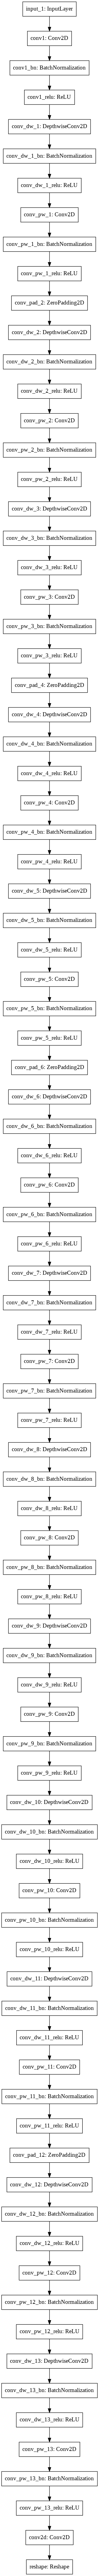

In [22]:
tf.keras.utils.plot_model(model=model)

### Define a custom loss function IoU which calculates Intersection Over Union

In [23]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tf.keras.backend.epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [24]:
model.compile(loss='mse', optimizer='Adam', metrics=[IoU])

In [25]:
model.fit(batch_images, coords, batch_size=32, epochs=30, verbose=1 )

Epoch 1/30
6/6 [==============================] - 33s 97ms/step - loss: 4059.2222 - IoU: 0.0885
Epoch 2/30
6/6 [==============================] - 0s 58ms/step - loss: 758.2087 - IoU: 0.4369
Epoch 3/30
6/6 [==============================] - 0s 59ms/step - loss: 485.4688 - IoU: 0.5612
Epoch 4/30
6/6 [==============================] - 0s 58ms/step - loss: 615.7357 - IoU: 0.5506
Epoch 5/30
6/6 [==============================] - 0s 58ms/step - loss: 336.9297 - IoU: 0.6216
Epoch 6/30
6/6 [==============================] - 0s 61ms/step - loss: 195.8734 - IoU: 0.6561
Epoch 7/30
6/6 [==============================] - 0s 65ms/step - loss: 203.1146 - IoU: 0.6460
Epoch 8/30
6/6 [==============================] - 0s 63ms/step - loss: 163.9498 - IoU: 0.6971
Epoch 9/30
6/6 [==============================] - 0s 65ms/step - loss: 124.2579 - IoU: 0.7376
Epoch 10/30
6/6 [==============================] - 0s 66ms/step - loss: 117.1629 - IoU: 0.7623
Epoch 11/30
6/6 [==============================] - 0s 68m

### Pick a test image from the given data

In [26]:
# all_images = os.listdir('images')
# test_data = []
# for img in all_images:
#   if img not in data_raw['filename'].values:
#     test_data.append(img)
# print(len(test_data))

In [27]:
def preprocess_image(test):
  img = cv2.imread(test)
  img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return tf.keras.applications.mobilenet.preprocess_input(np.array(img, dtype=np.float32))

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [28]:
# Selecting random image as test image.
from random import randint
value = randint(0,173)
test_img_name = paths[value]
test_img = preprocess_image(test_img_name)

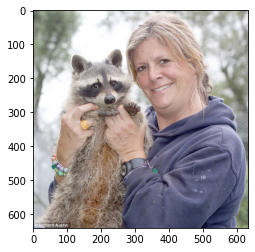

In [29]:
# Opening origninal image
from PIL import Image
unscaled = Image.open(test_img_name)
plt.imshow(unscaled)

In [30]:
image_width , image_height = unscaled.size[0] , unscaled.size[1]

### Predict the coordinates of the bounding box for the given test image

In [31]:
region = model.predict(np.expand_dims(test_img,axis=0))[0]
region

array([  7.0691185,  18.149837 ,  65.53462  , 126.85557  ], dtype=float32)

In [32]:
coords[value]

array([  6.25867508,  16.37441498,  65.61514196, 128.        ])

### Inference:- Comparing predicted BBox to original BBox, there's only small difference.

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

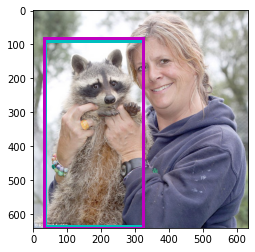

In [33]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

x2 = int(coords[value][0] * image_width / IMAGE_SIZE) # Scale the BBox
y2 = int(coords[value][1] * image_height / IMAGE_SIZE)

x3 = int((coords[value][2]) * image_width / IMAGE_SIZE)
y3 = int((coords[value][3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect1 = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=3, edgecolor='c', facecolor='none') # Predicted BBox
rect2 = patches.Rectangle((x2, y2), (x3 - x2), (y3 - y2) , linewidth=3, edgecolor='m', facecolor='none')  # Groundtruth BBOX

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)

plt.show()

### Inference:- The differnce in precdicted BBox to ground truth can be visible in the plot above.

# VGG16 Implementation

# VGG 16 Implementation
### Define a variable Image_size which takes accurate input according to the VGG16 model. 

In [34]:
Image_size = 224

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 224 * 224 

In [35]:
path = []
co_ords = np.zeros((len(data_raw),4))

for index, row in data_raw.iterrows():
  filename = row['filename']
  path.append(os.path.join(os.getcwd(), "images", filename))

  co_ords[index][0] = (row['xmin'] / row['width']) * Image_size
  co_ords[index][1] = (row['ymin'] / row['height']) * Image_size
  co_ords[index][2] = (row['xmax'] / row['width']) * Image_size
  co_ords[index][3] = (row['ymax'] / row['height']) * Image_size

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the VGG16 accepts 3 channels as inputs   

In [36]:
batch_images_vgg = np.zeros((len(paths), Image_size, Image_size, 3))
for i, Image in enumerate(paths):
  #Read the image
  img = cv2.imread(Image)
  #Resize the image
  img = cv2.resize(img, (Image_size, Image_size), interpolation=cv2.INTER_NEAREST)
  #Convert BGR format (used by opencv to RGB format used by matplotlib)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # Preprocessing the image for VGG16
  batch_images_vgg[i] = tf.keras.applications.vgg16.preprocess_input(np.array(img, dtype=np.float32))

### Define a vgg16 model and plot the model using plot_model function.
Hint:- Use RepeatVector,Conv1D,GlobalAveragePooling2D(optional to learner)

In [37]:
# Clear any existing model in memory
tf.keras.backend.clear_session()

# Loading MobileNet model
model_vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(Image_size, Image_size, 3))

# Freezing all the layers
for layer in model_vgg.layers:
  layer.trainable = False

# Adding convolution layers and reshaping for the output as 4 coordinates
x = model_vgg.layers[-1].output
x = tf.keras.layers.Conv2D(4, kernel_size=7)(x)
x = tf.keras.layers.Reshape((4,))(x)
model_vgg = tf.keras.Model(inputs = model_vgg.input, outputs = x)

58892288/58889256 [==============================] - 0s 0us/step


### Plot the Vgg16 model using plot_model function.

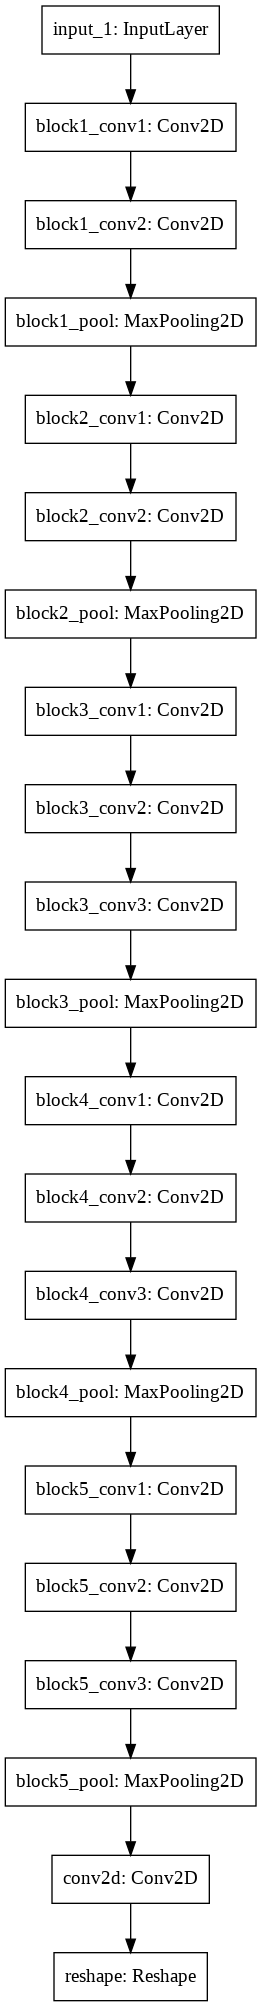

In [38]:
tf.keras.utils.plot_model(model=model_vgg)

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [39]:
model_vgg.compile(loss='mse', optimizer='Adam', metrics=[IoU])
import datetime
log_dir = "vgg_logs/fit"
tf_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir,histogram_freq= 1)
model_vgg.fit(batch_images_vgg, co_ords, batch_size=32, epochs=30, verbose=1, callbacks= [tf_callback])

Epoch 1/30
6/6 [==============================] - 10s 789ms/step - loss: 6792.8750 - IoU: 0.2958
Epoch 2/30
6/6 [==============================] - 1s 148ms/step - loss: 2934.5830 - IoU: 0.4381
Epoch 3/30
6/6 [==============================] - 1s 146ms/step - loss: 2701.7036 - IoU: 0.3518
Epoch 4/30
6/6 [==============================] - 1s 146ms/step - loss: 1543.9052 - IoU: 0.5208
Epoch 5/30
6/6 [==============================] - 1s 145ms/step - loss: 726.2736 - IoU: 0.6048
Epoch 6/30
6/6 [==============================] - 1s 150ms/step - loss: 643.3475 - IoU: 0.6270
Epoch 7/30
6/6 [==============================] - 1s 147ms/step - loss: 571.3132 - IoU: 0.6592
Epoch 8/30
6/6 [==============================] - 1s 150ms/step - loss: 412.3112 - IoU: 0.7057
Epoch 9/30
6/6 [==============================] - 1s 151ms/step - loss: 345.4128 - IoU: 0.7327
Epoch 10/30
6/6 [==============================] - 1s 149ms/step - loss: 298.5207 - IoU: 0.7590
Epoch 11/30
6/6 [===========================

### Pick a test image from the given data

In [40]:
def preprocess_image_vgg(test):
  img = cv2.imread(test)
  img = cv2.resize(img, (Image_size, Image_size), interpolation=cv2.INTER_NEAREST)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return tf.keras.applications.vgg16.preprocess_input(np.array(img, dtype=np.float32))

### Resize the image to 224 * 224 and preprocess the image for the VGG16

In [41]:
test_img_name_vgg = path[value]
test_img_vgg = preprocess_image_vgg(test_img_name_vgg)

### Predict the coordinates of the bounding box for the given test image

In [42]:
vgg_region = model_vgg.predict(np.expand_dims(test_img_vgg,axis=0))[0]
vgg_region

array([ 12.274002,  34.2582  , 115.78917 , 223.85788 ], dtype=float32)

In [43]:
co_ords[value]

array([ 10.95268139,  28.65522621, 114.82649842, 224.        ])

### Inference:- Comparing predicted BBox to original BBox, there's a slight difference in some values.

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

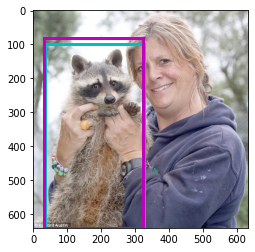

In [44]:
x0 = int(vgg_region[0] * image_width / Image_size) # Scaling the predicted BBox
y0 = int(vgg_region[1] * image_height / Image_size)

x1 = int((vgg_region[2]) * image_width / Image_size)
y1 = int((vgg_region[3]) * image_height / Image_size)

x2 = int(co_ords[value][0] * image_width / Image_size) # Scaling the original BBox
y2 = int(co_ords[value][1] * image_height / Image_size)

x3 = int((co_ords[value][2]) * image_width / Image_size)
y3 = int((co_ords[value][3]) * image_height / Image_size)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect1 = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=3, edgecolor='c', facecolor='none') # Predicted BBox
rect2 = patches.Rectangle((x2, y2), (x3 - x2), (y3 - y2) , linewidth=3, edgecolor='m', facecolor='none') # Groundtruth BBox

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)

plt.show()

### Inference:- The differnce in precdicted BBox to ground truth can be visible in the plot above.

### Visualizing model details in tensorboard

In [ ]:
!tensorboard dev upload --logdir vgg_logs/fit

2021-08-08 17:51:27.972112: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

vgg_logs/fit

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 

# Infernces:-
### 1. All the layers in both transfer learning models are frozen, since MobileNet has more layer than VGG, its better performing.
### 2. Overall performance can be improved by opening some layers and also by adding some more layes at the end.